# Brazilian Cities Analysis
This is an exploratory analysis of a broad [dataset](https://www.kaggle.com/crisparada/brazilian-cities) of Brazilian cities.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (12,7)

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

## Dataset Exploration, Feature Selection, and Initial Preprocessing

The creator provided a an explanation of each of the columns, which we load alongside the full dataset. 

In [40]:
features_ref = pd.read_csv('reference.csv', sep=';')
features_ref.head(5)

,FIELD,DESCRIPTION,REFERENCE,UNIT,SOURCE,Unnamed: 5
0,CITY,Name of the City,NaN,NaN,-,NaN
1,STATE,Name of the State,NaN,NaN,-,NaN
2,CAPITAL,1 if Capital of State,NaN,NaN,-,NaN
3,IBGE_RES_POP,Resident Population,2010,-,https://sidra.ibge.gov.br/tabela/1497,NaN
4,IBGE_RES_POP_BRAS,Resident Population Brazilian,2010,-,https://sidra.ibge.gov.br/tabela/1497,NaN


In [18]:
df = pd.read_csv('data.csv', sep=';')
df.head(10)

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
0,Abadia De Goiás,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,...,NaN,NaN,NaN,2158.0,1246.0,0.0,NaN,NaN,NaN,1.0
1,Abadia Dos Dourados,MG,0,6704.0,6704.0,0.0,2328.0,1481.0,847.0,4154.0,...,NaN,NaN,NaN,2227.0,1142.0,0.0,NaN,NaN,NaN,1.0
2,Abadiânia,GO,0,15757.0,15609.0,148.0,4655.0,3233.0,1422.0,10656.0,...,1.0,33724584.0,67091904.0,2838.0,1426.0,0.0,NaN,NaN,NaN,3.0
3,Abaeté,MG,0,22690.0,22690.0,0.0,7694.0,6667.0,1027.0,18464.0,...,2.0,44974716.0,371922572.0,6928.0,2953.0,0.0,NaN,NaN,NaN,4.0
4,Abaetetuba,PA,0,141100.0,141040.0,60.0,31061.0,19057.0,12004.0,82956.0,...,4.0,76181384.0,800078483.0,5277.0,25661.0,0.0,NaN,NaN,NaN,2.0
5,Abaiara,CE,0,10496.0,10496.0,0.0,2791.0,1251.0,1540.0,4538.0,...,NaN,NaN,NaN,553.0,1674.0,0.0,NaN,NaN,NaN,1.0
6,Abaíra,BA,0,8316.0,8316.0,0.0,2572.0,1193.0,1379.0,3725.0,...,NaN,NaN,NaN,896.0,696.0,0.0,NaN,NaN,NaN,1.0
7,Abaré,BA,0,17064.0,17064.0,0.0,4332.0,2379.0,1953.0,8994.0,...,0.0,21823314.0,0.0,613.0,1532.0,0.0,NaN,NaN,NaN,1.0
8,Abatiá,PR,0,7764.0,7764.0,0.0,2499.0,1877.0,622.0,5685.0,...,1.0,0.0,45976288.0,2168.0,912.0,0.0,NaN,NaN,NaN,1.0
9,Abdon Batista,SC,0,2653.0,2653.0,0.0,848.0,234.0,614.0,724.0,...,1.0,0.0,42909056.0,976.0,345.0,2.0,NaN,NaN,NaN,1.0


### Metadata

In [36]:
print('{} rows'.format(str(len(df.index))))
print('{} features'.format(str(len(df.columns))))
print('{} duplicate rows'.format(str(len(df.index)-len(df.drop_duplicates().index))))

df_temp = df.copy()
null_cols = []
for col in df_temp.columns:
    try:
        df_temp[col] = df_temp[col].apply(lambda x: np.isnan(x))
        if df_temp.groupby(col).count()['CITY'].sort_values().loc[False] > 0:
            null_cols.append(
                (col,
             round((1-df_temp.groupby(col).count()['CITY'].sort_values().loc[False]/len(df_temp.index))*100,1)))
    except TypeError:
        pass

null_cols = pd.DataFrame(
    null_cols, columns=['column', '% missing']).sort_values(by='% missing', ascending=False
)

print('{} rows with missing values'.format(len(null_cols.index)))

print('\nLeast well-defined features:')
null_cols.sort_values(by='% missing', ascending=False).head(10)

5573 rows
81 features
0 duplicate rows
74 rows with missing values

Least well-defined features:


,column,% missing
72,WAL-MART,98.2
70,UBER,97.8
71,MAC,97.0
59,HOTELS,84.1
60,BEDS,84.1
63,Pr_Bank,40.0
66,Pu_Assets,40.0
64,Pu_Bank,40.0
61,Pr_Agencies,40.0
65,Pr_Assets,40.0


We now select some interesting features for analysis and drop rows with irreconcilable missing values:

| Feature | Date |
| :-- | --- |
| City name                      | N/A  |
| State code                     | N/A  |
| is Capital? (yes/no)           | N/A  |
| Total resident population      | 2010 |
| Brazilian resident population  | 2010 |
| Foreign resident population    | 2010 |
| Total number of domestic units | 2010 |
| Number of rural domestic units | 2010 |
| Number of urban domestic units | 2010 |
| Total GDP                      | 2016 |
| GDP per capita                 | 2016 |
| IDHM (HDI)                     | 2010 |

In [43]:
features = [
    'CITY',
    'STATE',
    'CAPITAL',
    'IBGE_RES_POP', 
    'IBGE_RES_POP_BRAS', 
    'IBGE_RES_POP_ESTR',
    'IBGE_DU',
    'IBGE_DU_RURAL',
    'IBGE_DU_URBAN',
    'GDP',
    'GDP_CAPITA',
    'IDHM'
]

df2 = df[features].reset_index(drop=True)

df2['IBGE_RES_POP_BRAS'] = df2['IBGE_RES_POP_BRAS'].fillna(0)
df2['IBGE_RES_POP_ESTR'] = df2['IBGE_RES_POP_ESTR'].fillna(0)
df2['IBGE_DU_RURAL'] = df2['IBGE_DU_RURAL'].fillna(0)
df2['IBGE_DU_URBAN'] = df2['IBGE_DU_URBAN'].fillna(0)

null_ix = []
for f in features:
    try:
        null_ix += [i for i in df2.index if np.isnan(df2.loc[i, f])]
    except TypeError:
        pass

print('removed {}/{} rows with null values'.format(str(len(null_ix)), len(df2.index)))
df2 = df2.loc[[i for i in df2.index if i not in null_ix]].reset_index(drop=True)

removed 32/5573 rows with null values


## Visualizations
### Basic Metrics

<AxesSubplot:title={'center':'20 Largest Cities in Brazil'}, ylabel='CITY'>

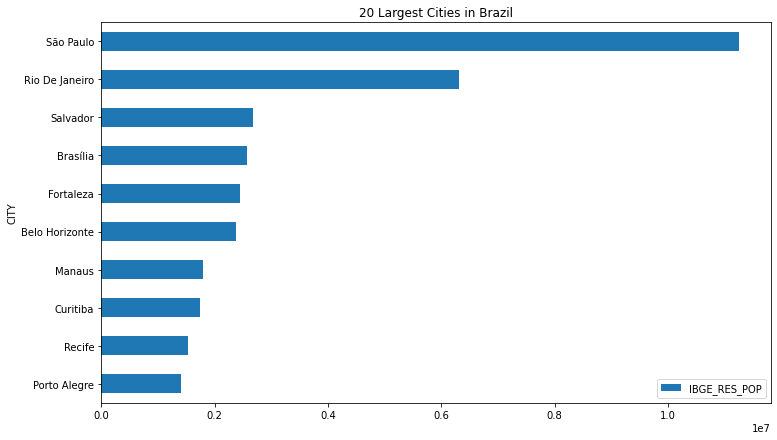

In [44]:
df2.sort_values(by='IBGE_RES_POP', ascending=False).head(10).sort_values(by='IBGE_RES_POP').plot.barh(
    x='CITY', y='IBGE_RES_POP', figsize=(12,7), title='20 Largest Cities in Brazil')

Because there is a massive drop in population between SP, Rio, and the remaining cities, it may be useful to consider a $\log$ transformation of the population when fitting models:

(-4.95, 103.95, 12.238611274628893, 16.42655090836713)

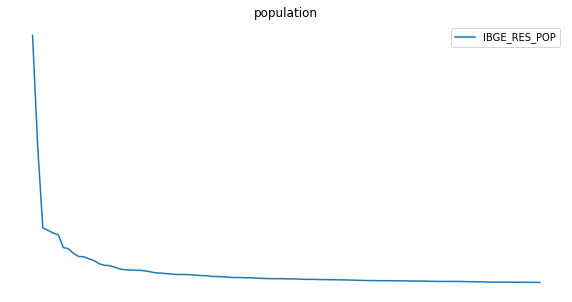

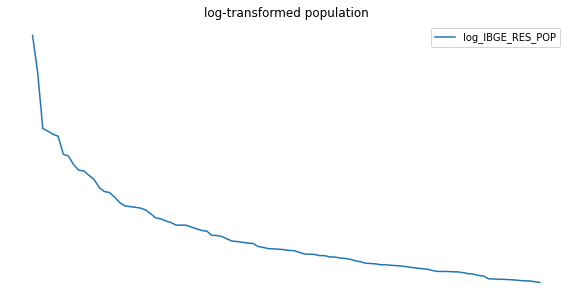

In [61]:
df3 = df2.copy()
df3['log_IBGE_RES_POP'] = df3['IBGE_RES_POP'].apply(math.log)

df3.sort_values(by='IBGE_RES_POP', ascending=False).head(100).sort_values(
    by='IBGE_RES_POP', ascending=False).plot(
    x='CITY', y=['IBGE_RES_POP'], figsize=(10,5), title='population')
plt.axis('off')

df3.sort_values(by='IBGE_RES_POP', ascending=False).head(100).sort_values(
    by='IBGE_RES_POP', ascending=False).plot(
    x='CITY', y=['log_IBGE_RES_POP'], figsize=(10,5), title='log-transformed population')
plt.axis('off')

We now reduce the dataset to cities with populations between 10,000 and 1,000,000 in order to remove unnecessary noise when looking for patterns in the visualizations. We denote visualizations over this reduced population by an asterisk (*) in the title.

In [80]:
cities100k = df2[(df2['IBGE_RES_POP']>=10000) & (df2['IBGE_RES_POP']<1000000)].sort_values(by='IDHM', ascending=False).reset_index(drop=True).rename(
    columns={'IDHM':'HDI'}
)

# feature adjustments
cities100k['IBGE_RES_POP_ESTR'] = cities100k['IBGE_RES_POP_ESTR'] / cities100k['IBGE_RES_POP']
cities100k['IBGE_RES_POP_LOG'] = cities100k['IBGE_RES_POP'].apply(math.log)
cities100k['IBGE_DU_RURAL'] = cities100k['IBGE_DU_RURAL'] / cities100k['IBGE_DU']

cities100k['Average HDI'] = np.mean(cities100k['HDI'])
cities100k['vs Average'] = (cities100k['HDI'] - cities100k['Average HDI']).apply(
    lambda x: ('+' if x>=0 else '')+str(round(x, 3)))

print("Most Developed Cities in Brazil*")
cities100k.sort_values(by='HDI', ascending=False).head(10)[['CITY', 'IBGE_RES_POP', 'STATE', 'HDI', 'vs Average']]

Most Developed Cities in Brazil*


,CITY,IBGE_RES_POP,STATE,HDI,vs Average
0,São Caetano Do Sul,149263.0,SP,0.862,+0.204
1,Florianópolis,421240.0,SC,0.847,+0.189
2,Balneário Camboriú,108089.0,SC,0.845,+0.187
3,Vitória,327801.0,ES,0.845,+0.187
4,Santos,419400.0,SP,0.840,+0.182
5,Niterói,487562.0,RJ,0.840,+0.182
6,Joaçaba,27020.0,SC,0.830,+0.172
7,Vinhedo,63611.0,SP,0.820,+0.162
8,Valinhos,106793.0,SP,0.820,+0.162
9,Jundiaí,370126.0,SP,0.820,+0.162


In [76]:
print("Least Developed Cities in Brazil*")
cities100k.sort_values(by='HDI', ascending=True).head(10)[['CITY', 'IBGE_RES_POP', 'STATE', 'HDI', 'vs Average']]

Least Developed Cities in Brazil*


,CITY,IBGE_RES_POP,STATE,HDI,vs Average
3036,Melgaço,24808.0,PA,0.418,-0.24
3035,Atalaia Do Norte,15153.0,AM,0.450,-0.208
3034,Chaves,21005.0,PA,0.453,-0.205
3033,Bagre,23864.0,PA,0.471,-0.187
3032,Cachoeira Do Piriá,26484.0,PA,0.473,-0.185
3031,Santa Isabel Do Rio Negro,18146.0,AM,0.479,-0.179
3030,Ipixuna,22254.0,AM,0.481,-0.177
3029,Portel,52172.0,PA,0.483,-0.175
3027,Inhapi,17898.0,AL,0.484,-0.174
3028,Anajás,24759.0,PA,0.484,-0.174


### Scatterplots and Correlations

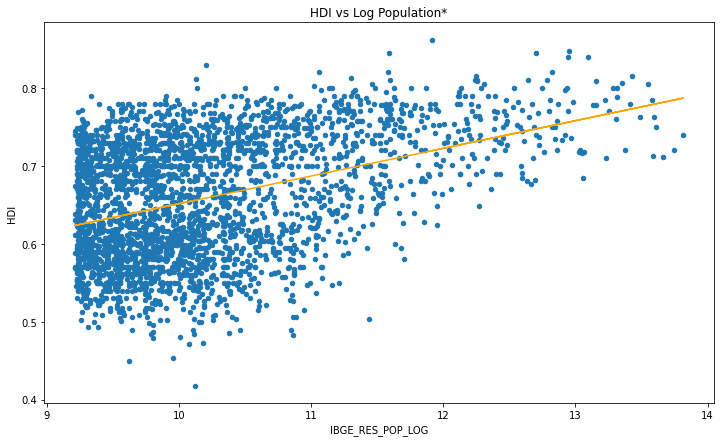

In [77]:
cities100k.plot.scatter(x='IBGE_RES_POP_LOG', y='HDI', figsize=(12,7), title='HDI vs Log Population*')

plt.plot(cities100k['IBGE_RES_POP_LOG'], 
         LinearRegression().fit(
             np.reshape(list(cities100k['IBGE_RES_POP_LOG']), (-1,1)), cities100k['HDI']
         ).predict(np.reshape(list(cities100k['IBGE_RES_POP_LOG']), (-1,1))), c='orange')

<AxesSubplot:title={'center':'HDI vs % Foreign Population (total population over 100,000) - ZOOMED IN'}, xlabel='IBGE_RES_POP_ESTR', ylabel='HDI'>

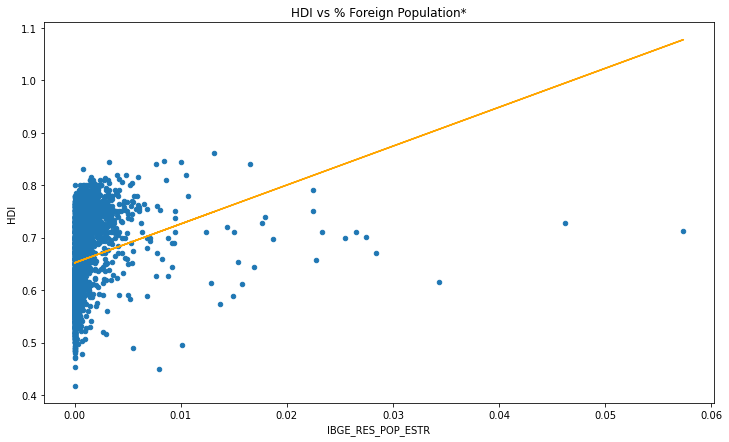

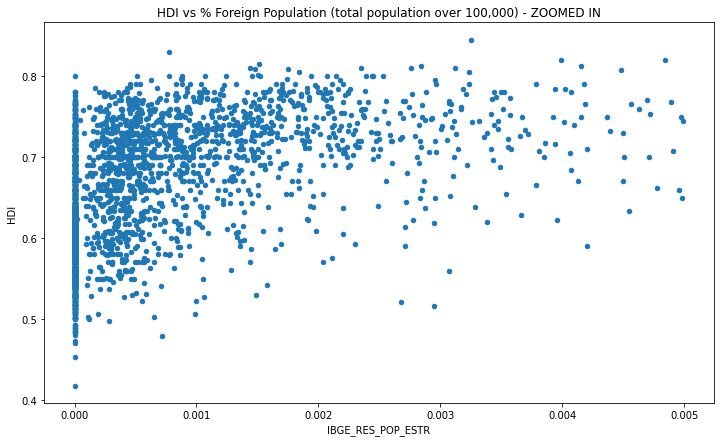

In [78]:
cities100k.plot.scatter(
    x='IBGE_RES_POP_ESTR', y='HDI', figsize=(12,7), 
    title='HDI vs % Foreign Population*')

plt.plot(cities100k['IBGE_RES_POP_ESTR'], 
         LinearRegression().fit(
             np.reshape(list(cities100k['IBGE_RES_POP_ESTR']), (-1,1)), cities100k['HDI']
         ).predict(np.reshape(list(cities100k['IBGE_RES_POP_ESTR']), (-1,1))), c='orange')

cities100k[(cities100k['IBGE_RES_POP_ESTR']<=0.005)].plot.scatter(
    x='IBGE_RES_POP_ESTR', y='HDI', figsize=(12,7), 
    title='HDI vs % Foreign Population (total population over 100,000) - ZOOMED IN')

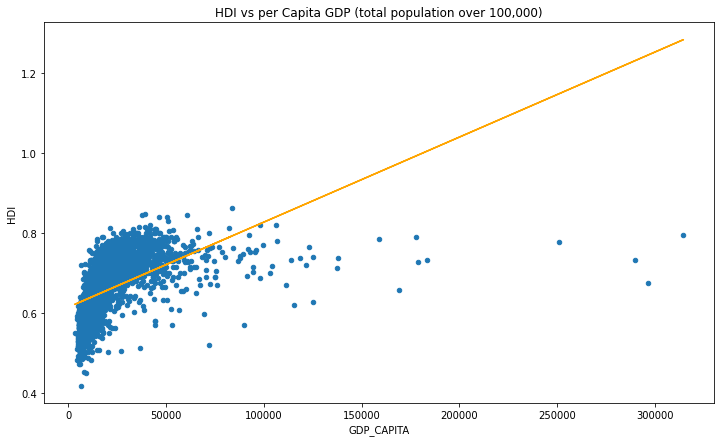

In [79]:
cities100k.plot.scatter(
    x='GDP_CAPITA', y='HDI', figsize=(12,7),
    title='HDI vs per Capita GDP (total population over 100,000)')

plt.plot(cities100k['GDP_CAPITA'], 
         LinearRegression().fit(
             np.reshape(list(cities100k['GDP_CAPITA']), (-1,1)), cities100k['HDI']
         ).predict(np.reshape(list(cities100k['GDP_CAPITA']), (-1,1))), c='orange')

Text(0.5, 1.0, 'HDI vs Proportion of Rural Domestic Units')

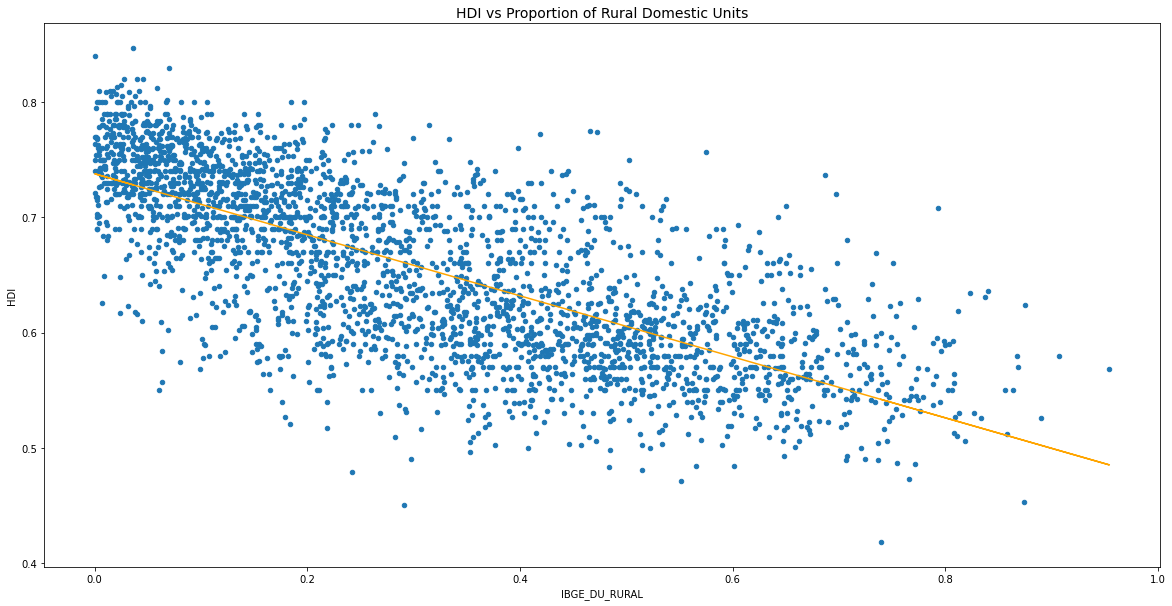

In [84]:
cities100k[cities100k['IBGE_DU_RURAL']>0].plot.scatter(x='IBGE_DU_RURAL', y='HDI', figsize=(20,10))
plt.plot(cities100k[cities100k['IBGE_DU_RURAL']>0]['IBGE_DU_RURAL'], 
         LinearRegression().fit(
             np.reshape(list(cities100k[cities100k['IBGE_DU_RURAL']>0]['IBGE_DU_RURAL']), (-1,1)), 
             cities100k[cities100k['IBGE_DU_RURAL']>0]['HDI']
         ).predict(
             np.reshape(list(cities100k[cities100k['IBGE_DU_RURAL']>0]['IBGE_DU_RURAL']), (-1,1))), c='orange')

plt.title('HDI vs Proportion of Rural Domestic Units', fontsize=14)

Comparing HDI against the Proportion of Rurl Domestic Units shows the clearest correlation of any tried, maybe serving as a more reflective flavour of pure population. For this reason, we will proceed to quantify this relationship with a simple linear regression.

In [128]:
lr_df = cities100k[cities100k['IBGE_DU_RURAL']>0][['IBGE_DU_RURAL', 'HDI']].rename(
    columns={'IBGE_DU_RURAL': 'x', 'HDI': 'y'}
)

lr_df['intecept'] = 1

X = np.array(lr_df[['intecept', 'x']])
y = np.array(lr_df['y'])

lr = sm.OLS(y, X)
mod = lr.fit(const=True)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     3438.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:23:45   Log-Likelihood:                 4586.8
No. Observations:                2980   AIC:                            -9170.
Df Residuals:                    2978   BIC:                            -9158.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7378      0.002    439.201      0.000       0.735       0.741
x1            -0.2648      0.005    -58.633      0.000      -0.274      -0.256
==============================================================================
Omnibus:                       27.723   Durbin-Watson:                   1.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.706
Skew:                          -0.218   Prob(JB):                     5.84e-07
Kurtosis:                       3.202   Cond. No.                         5.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

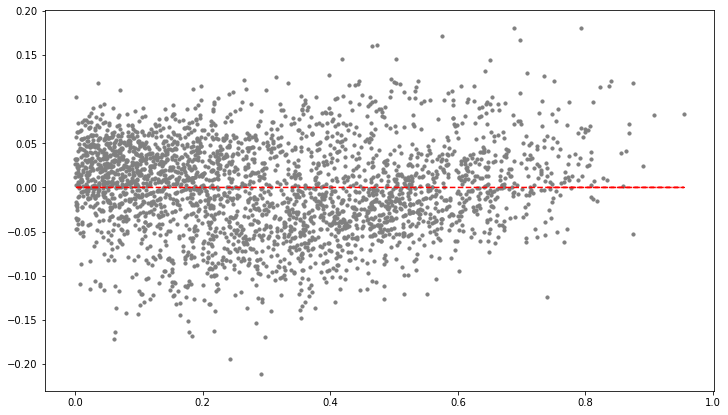

In [129]:
plt.scatter(lr_df['x'], y-mod.fittedvalues, s=10, c='gray')
plt.plot(lr_df['x'], np.repeat(0, len(lr_df['x'])), c='red', linestyle='dashed')

The residual assumptions seem to broadly hold - especially considering that the data is skewed towards lower values of `IGBE_DU_RURAL`. With $R^2=0.536$ and statistically significant parameters, we will take the linear relationship at face value for now.

## clustering

In [ ]:
X = cities100k[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)

X['IBGE_RES_POP_ESTR'] = X['IBGE_RES_POP_ESTR'] / X['IBGE_RES_POP']

In [ ]:
X_base = X[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)

km_base = KMeans(random_state=0, n_clusters=4).fit(X_base)
X['km_base'] = km_base.labels_
X.groupby('km_base').mean()

In [ ]:
X_norm1 = X[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)
X_norm1['IBGE_RES_POP_ESTR'] = X_norm1['IBGE_RES_POP_ESTR'] * 20
X_norm1['IBGE_RES_POP'] = X_norm1['IBGE_RES_POP'].apply(math.log)
X_norm1['HDI'] = X_norm1['HDI'] * 10
X_norm1['GDP_CAPITA'] = X_norm1['GDP_CAPITA'] / 10000

print(pd.DataFrame(
    [(col, min(X_norm1[col]), max(X_norm1[col]), np.mean(X_norm1[col])) for col in X_norm1.columns], columns=[
    'column', 'min', 'max', 'mean'
]))

km_norm1 = KMeans(random_state=0, n_clusters=4).fit(X_norm1)
X['km_norm1'] = km_norm1.labels_
X.groupby('km_norm1').mean()[[col for col in X.columns if 'km_' not in col]]

In [ ]:
print('MinMaxScaler')
X_norm2 = X[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)

X_norm2['IBGE_RES_POP'] = X_norm2['IBGE_RES_POP'].apply(math.log)

X_norm2 = pd.DataFrame(MinMaxScaler().fit_transform(X_norm2), columns=X_norm2.columns)

km_norm2 = KMeans(random_state=0, n_clusters=4).fit(X_norm2)
X['km_norm2'] = km_norm2.labels_

print(pd.DataFrame(
    [(col, min(X_norm2[col]), max(X_norm2[col]), np.mean(X_norm2[col])) for col in X_norm2.columns], columns=[
    'column', 'min', 'max', 'mean'
]))
X.groupby('km_norm2').mean()[[col for col in X.columns if 'km_' not in col]]

In [ ]:
print('\nMaxAbsScaler')
X_norm3 = X[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)

X_norm3['IBGE_RES_POP'] = X_norm3['IBGE_RES_POP'].apply(math.log)

X_norm3 = pd.DataFrame(MaxAbsScaler().fit_transform(X_norm3), columns=X_norm3.columns)
print(pd.DataFrame(
    [(col, min(X_norm3[col]), max(X_norm3[col]), np.mean(X_norm3[col])) for col in X_norm3.columns], columns=[
    'column', 'min', 'max', 'mean'
]))

km_norm3 = KMeans(random_state=0, n_clusters=4).fit(X_norm3)
X['km_norm3'] = km_norm3.labels_
X.groupby('km_norm3').mean()[[col for col in X.columns if 'km_' not in col]]

In [ ]:
print('\nStandardScaler')
X_norm4 = X[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)

X_norm4['IBGE_RES_POP'] = X_norm4['IBGE_RES_POP'].apply(math.log)

X_norm4 = pd.DataFrame(StandardScaler().fit_transform(X_norm4), columns=X_norm4.columns)
print(pd.DataFrame(
    [(col, min(X_norm4[col]), max(X_norm4[col]), np.mean(X_norm4[col])) for col in X_norm4.columns], columns=[
    'column', 'min', 'max', 'mean'
]))

km_norm4 = KMeans(random_state=0, n_clusters=4).fit(X_norm4)
X['km_norm4'] = km_norm4.labels_
X.groupby('km_norm4').mean()[[col for col in X.columns if 'km_' not in col]].sort_values(by='IBGE_RES_POP')

In [ ]:
print('\nStandardScaler')
X_norm5 = X[
    ['CAPITAL', 'IBGE_RES_POP', 'IBGE_RES_POP_ESTR', 'IBGE_DU', 'IBGE_DU_RURAL', 'GDP_CAPITA', 'HDI']
].reset_index(drop=True)

X_norm5 = pd.DataFrame(StandardScaler().fit_transform(X_norm5), columns=X_norm5.columns)
print(pd.DataFrame(
    [(col, min(X_norm5[col]), max(X_norm5[col]), np.mean(X_norm5[col])) for col in X_norm5.columns], columns=[
    'column', 'min', 'max', 'mean'
]))

km_norm5 = KMeans(random_state=0, n_clusters=4).fit(X_norm5)
X['km_norm4'] = km_norm4.labels_
X.groupby('km_norm4').mean()[[col for col in X.columns if 'km_' not in col]].sort_values(by='IBGE_RES_POP')

In [ ]:
plt.scatter(X['IBGE_RES_POP'], X['HDI'], c=km_norm2.labels_, s=20)
plt.title('MinMaxScaler', fontsize=15)
plt.show()
plt.scatter(X['IBGE_RES_POP'], X['HDI'], c=km_norm3.labels_, s=20)
plt.title('MaxAbsScaler', fontsize=15)
plt.show()
plt.scatter(X['IBGE_RES_POP'], X['HDI'], c=km_norm4.labels_, s=20)
plt.title('StandardScaler with log transformation', fontsize=15)
plt.show()

In [ ]:
plt.scatter(X['IBGE_RES_POP'], X['HDI'], c=km_norm5.labels_, s=20)
plt.title('StandardScaler without log transformation', fontsize=15)